In [21]:
from pringles.simulator import Simulator
mySimulator = Simulator(cdpp_bin_path='bin/', user_models_dir='src/')

In [22]:
atomics = dict([(atomic.__name__, atomic) for atomic in mySimulator.atomic_registry.discovered_atomics])
Server = atomics['Server']
Dispatcher = atomics['Dispatcher']
ServerQueue = atomics['ServerQueue']

In [23]:
from pringles.models import Coupled
from pringles.models.errors import PortNotFoundException
number_of_servers = 3
a_dispatcher = Dispatcher("a_dispatcher", 
                          numberOfServers=number_of_servers, 
                          server0="free",
                          server1="free",
                          server2="free")
servers = {}
for i in range(number_of_servers):
    server_name = "server" + str(i)
    servers[i] = Server(server_name, initialStatus="free", mean=10.0, setupTime="0:0:10:0")
    try:
        a_dispatcher.get_port(server_name)
    except PortNotFoundException:
        a_dispatcher.add_outport(server_name)

a_queue = ServerQueue("a_queue", size=10)
    
print("--Dispatcher ports")
print("Inport names: ", [port.name for port in a_dispatcher.inports])
print("Outport names: ", [port.name for port in a_dispatcher.outports])

print("--Server ports--")
print("Inport names: ", [port.name for port in servers[0].inports])
print("Outport names: ", [port.name for port in servers[0].outports])

print("--ServerQueue ports--")
print("Inport names: ", [port.name for port in a_queue.inports])
print("Outport names: ", [port.name for port in a_queue.outports])

--Dispatcher ports
Inport names:  ['newJob', 'jobDone', 'serverStatus']
Outport names:  ['requestJob', 'server0', 'server1', 'server2']
--Server ports--
Inport names:  ['job', 'powerSignal']
Outport names:  ['done', 'ready']
--ServerQueue ports--
Inport names:  ['in', 'emit']
Outport names:  ['out', 'discarded', 'queueLoad', 'loadAvg']


In [52]:
subcomponents = [a_dispatcher, a_queue]
for i in range(number_of_servers):
    subcomponents.append(servers[i])
    
    
top_model = (Coupled(name='top', subcomponents=subcomponents)
             .add_inport("newJob")
             .add_inport("serverStatus")
             
             .add_coupling('serverStatus', a_dispatcher.get_port("serverStatus"))
            
             .add_coupling(a_dispatcher.get_port('server0'), servers[0].get_port('job'))
             .add_coupling(a_dispatcher.get_port('server1'), servers[1].get_port('job'))
             .add_coupling(a_dispatcher.get_port('server2'), servers[2].get_port('job'))
             
             .add_coupling(servers[0].get_port('done'), a_dispatcher.get_port('jobDone'))
             .add_coupling(servers[1].get_port('done'), a_dispatcher.get_port('jobDone'))
             .add_coupling(servers[2].get_port('done'), a_dispatcher.get_port('jobDone'))
             
             .add_coupling("newJob", a_queue.get_port('in'))
             .add_coupling(a_queue.get_port("out"), a_dispatcher.get_port("newJob"))
             .add_coupling(a_dispatcher.get_port("requestJob"), a_queue.get_port("emit"))

             
            )
top_model

In [25]:
from pringles.simulator import Simulation, Event
from pringles.utils import VirtualTime
# Empiezan los 3 servidores prendidos. Y se avisa que el 2 está apagado (habría que mandarle tmb que se apague)
# Llega un Job a los 25 y el dispatcher lo debería mandar al server 0 porque es el de menor ID
# Llega que se prendió de nuevo el server 2
# Llega otro Job a los 38 y se los manda de nuevo al server 0 (en la simulación el server 0 termina el job anterior
    # en el segundo 36)
# Llega en 40 que se apagó el 0, pero el lo tenía en busy, espera que se apague y lo pasa a off
# Llega en 42 un Job y como el 0 está en apagado/busy, se lo manda al server 1
# Llega en 43 que se apague el 1, espera que se termine el job y lo apaga
# Llega en 44 un Job y se lo manda al server 2, el único prendido

sim_events = [
    Event(VirtualTime(0,0,20,0,0), top_model.get_port('serverStatus'), [float(2),float(0)]),
    Event(VirtualTime(0,0,25,0,0), top_model.get_port('newJob'), float(1)),
    Event(VirtualTime(0,0,35,0,0), top_model.get_port('serverStatus'), [float(2),float(1)]),
    Event(VirtualTime(0,0,38,0,0), top_model.get_port('newJob'), float(1)),
    Event(VirtualTime(0,0,40,0,0), top_model.get_port('serverStatus'), [float(0),float(0)]),
    Event(VirtualTime(0,0,42,0,0), top_model.get_port('newJob'), float(1)),
    Event(VirtualTime(0,0,43,0,0), top_model.get_port('serverStatus'), [float(1),float(0)]),
    Event(VirtualTime(0,0,44,0,0), top_model.get_port('newJob'), float(1)),
]


a_simulation = Simulation(top_model = top_model, 
                          duration = VirtualTime.of_minutes(50), 
                          events=sim_events,
                          working_dir='sim_results/'
                         )

results = mySimulator.run_simulation(a_simulation)

In [26]:
print(results.get_process_output())

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from sim_results/2019-11-16-191754-f6850d1c97254fcea4a4c0d6c22d3c4c/top_model
Loading events from sim_results/2019-11-16-191754-f6850d1c97254fcea4a4c0d6c22d3c4c/events
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Mess

In [43]:
print(results.get_process_error_output())

At 00:50:00:000:0


In [44]:
display(results.output_df.head(100))

,time,port,value


In [45]:
print(results.logs_dfs.keys(),'\n\n')
display(results.logs_dfs['ParallelRoot'].head())

dict_keys(['server2', 'server1', 'server0', 'a_queue', 'a_dispatcher', 'top', 'ParallelRoot']) 




,0,1,message_type,time,model_origin,port,value,model_dest


In [46]:
# Veamos que le llegan al server 0 los primneros 2 jobs, hasta que lo apagan en segundo 40
display(results.logs_dfs['server0'])

,0,1,message_type,time,model_origin,port,value,model_dest
0,0,L,X,00:00:25:000,top(06),job,0.0,server0(03)


In [47]:
# Veamos que el siguiente job le llega al server 1 en el segundo 42, y luego lo apagan en el segundo 43
# Y se espera a que termine para apagarlo
display(results.logs_dfs['server1'])

,0,1,message_type,time,model_origin,port,value,model_dest
0,0,L,X,00:00:38:000,top(06),job,1.0,server1(04)
1,0,L,X,00:01:05:000,top(06),job,5.0,server1(04)
2,0,L,X,00:01:24:054,top(06),job,7.0,server1(04)
3,0,L,X,00:01:34:798,top(06),job,8.0,server1(04)
4,0,L,X,00:01:36:863,top(06),job,9.0,server1(04)


In [48]:
# Por último cuando el 0 y el 1 están apagados, cuando llega el último job en el segundo 44, se lo envía al server 2
# que lo termina (ver logs dispatcher)
display(results.logs_dfs['server2'])

,0,1,message_type,time,model_origin,port,value,model_dest
0,0,L,X,00:00:42:000,top(06),job,2.0,server2(05)
1,0,L,X,00:00:52:075,top(06),job,3.0,server2(05)
2,0,L,X,00:01:00:000,top(06),job,4.0,server2(05)
3,0,L,X,00:01:20:043,top(06),job,6.0,server2(05)


In [49]:
display(results.logs_dfs['a_dispatcher'])

,0,1,message_type,time,model_origin,port,value,model_dest
0,0,L,X,00:00:20:000,top(06),serverstatus,"(2.0, 0.0)",a_dispatcher(01)
1,0,L,X,00:00:25:000,top(06),newjob,0,a_dispatcher(01)
2,0,L,X,00:00:35:000,top(06),serverstatus,"(2.0, 1.0)",a_dispatcher(01)
3,0,L,X,00:00:38:000,top(06),newjob,1,a_dispatcher(01)
4,0,L,X,00:00:40:000,top(06),serverstatus,"(0.0, 0.0)",a_dispatcher(01)
5,0,L,X,00:00:42:000,top(06),newjob,2,a_dispatcher(01)
6,0,L,X,00:00:43:000,top(06),serverstatus,"(1.0, 0.0)",a_dispatcher(01)
7,0,L,X,00:00:52:075,top(06),jobdone,2,a_dispatcher(01)
8,0,L,X,00:00:52:075,top(06),newjob,3,a_dispatcher(01)
9,0,L,X,00:00:53:288,top(06),jobdone,0,a_dispatcher(01)


In [50]:
display(results.logs_dfs['server0'])

,0,1,message_type,time,model_origin,port,value,model_dest
0,0,L,X,00:00:25:000,top(06),job,0.0,server0(03)


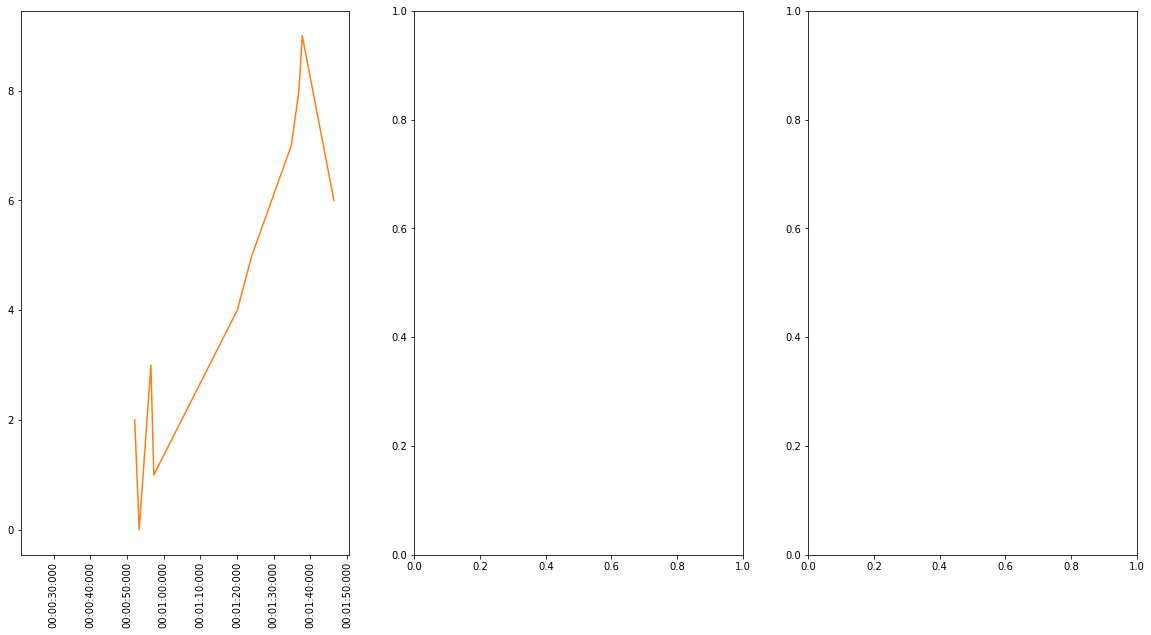

In [51]:
import matplotlib.pyplot as plt
from pringles.utils import vtime_decorate
import pandas as pd

logname = 'a_dispatcher'
portname = 'jobdone'
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

results.plot_port('server0', 'job', axes=vtime_decorate(axes[0]), index=0)
results.plot_port('a_dispatcher', 'jobdone', axes=vtime_decorate(axes[0]), index=0)